In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
from keras import layers
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import pandas as pd
import scipy
from tqdm import tqdm
import tensorflow as tf
from collections import Counter
import json
import itertools
from keras.layers import Dense,Dropout,Activation,Add,MaxPooling2D,Conv2D,Flatten,BatchNormalization
import os
from PIL import Image
import cv2
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve,roc_auc_score, auc
import matplotlib.pyplot as plt
import seaborn as sns

Data Gathering and Preprocessing

In [3]:
# create data generator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

# Define the data generator for the validation and test sets
val_test_datagen = ImageDataGenerator(rescale=1./255)

# fit the model on data
train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Group_Project_Data/Train',
    target_size=(64,64),
    batch_size=32,
    class_mode='binary')
    
validation_generator = val_test_datagen.flow_from_directory(
    '/content/drive/MyDrive/Group_Project_Data/Valid',
    target_size=(64,64),
    batch_size=32,
    class_mode='binary')

Found 6000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [4]:
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    
    for root, _, files in os.walk(DIR):
        for file in files:
            if file.endswith('.png'):
                PATH = os.path.join(root,file)

                img = read(PATH)

                img = cv2.resize(img, (RESIZE,RESIZE))

                IMG.append(np.array(img))
    return IMG

real_train = np.array(Dataset_loader('/content/drive/MyDrive/Group_Project_Data/Train/Real',64))
fake_train = np.array(Dataset_loader('/content/drive/MyDrive/Group_Project_Data/Train/Fake',64))
real_test = np.array(Dataset_loader('/content/drive/MyDrive/Group_Project_Data/Valid/Real',64))
fake_test = np.array(Dataset_loader('/content/drive/MyDrive/Group_Project_Data/Valid/Fake',64))

In [5]:
# Create labels
real_train_label = np.ones(len(real_train))
fake_train_label = np.zeros(len(fake_train))
real_test_label = np.ones(len(real_test))
fake_test_label = np.zeros(len(fake_test))

# Merge data 
X_train = np.concatenate((real_train, fake_train), axis = 0)
Y_train = np.concatenate((real_train_label, fake_train_label), axis = 0)
X_test = np.concatenate((real_test, fake_test), axis = 0)
Y_test = np.concatenate((real_test_label, fake_test_label), axis = 0)

# Shuffle train data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

# Shuffle test data
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

**Define Model Architecture**

In [6]:
# define input shape
input_shape = (64, 64, 3)

# define model architecture
model = tf.keras.Sequential([
    layers.Conv2D(8, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(16, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.5), # Adding Dropout layer with a rate of 0.5
    layers.Dense(1, activation='sigmoid')
])

# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 8)         224       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 16)        1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 32)        4640      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 32)         0

In [7]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

#define the model checkpoint callback this will keep on saving the model as a physical file
model_checkpoint = ModelCheckpoint('cnn.h5', verbose=1, save_best_only=True)

**Train Model**

In [8]:
#define a function to fit the model
def fit_and_evaluate(train, test, EPOCHS=20, BATCH_SIZE=32):

    results = model.fit(train, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[early_stopping, model_checkpoint], 
              verbose=1, validation_data=test) 
    
    print("Val Score: ", model.evaluate(test))
    return results

In [9]:
n_folds=4

#save the model history in a list after fitting so that we can plot later
model_history = [] 

for i in range(n_folds):
    print("Training on Fold: ",i+1)

    model_history.append(fit_and_evaluate(train_generator,validation_generator))
    
    print("======="*12, end="\n\n\n")

Training on Fold:  1
Epoch 1/20
188/188 [==============================] - ETA: 0s - loss: 0.2596 - accuracy: 0.8843
Epoch 1: val_loss improved from inf to 0.02986, saving model to cnn.h5
188/188 [==============================] - 47s 241ms/step - loss: 0.2596 - accuracy: 0.8843 - val_loss: 0.0299 - val_accuracy: 0.9895
Epoch 2/20
188/188 [==============================] - ETA: 0s - loss: 0.0753 - accuracy: 0.9720
Epoch 2: val_loss improved from 0.02986 to 0.01052, saving model to cnn.h5
188/188 [==============================] - 40s 214ms/step - loss: 0.0753 - accuracy: 0.9720 - val_loss: 0.0105 - val_accuracy: 0.9970
Epoch 3/20
188/188 [==============================] - ETA: 0s - loss: 0.0608 - accuracy: 0.9743
Epoch 3: val_loss did not improve from 0.01052
188/188 [==============================] - 39s 209ms/step - loss: 0.0608 - accuracy: 0.9743 - val_loss: 0.0133 - val_accuracy: 0.9950
Epoch 4/20
188/188 [==============================] - ETA: 0s - loss: 0.0363 - accuracy: 0.9867


Evalute Model

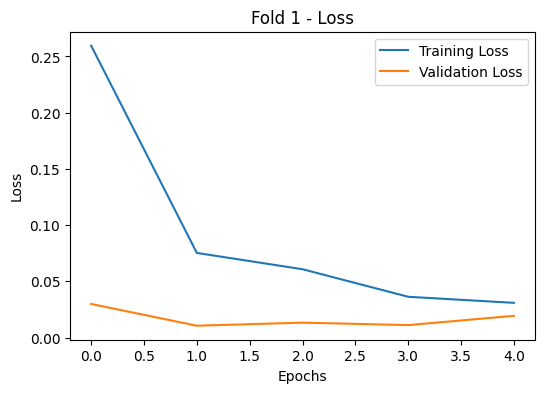

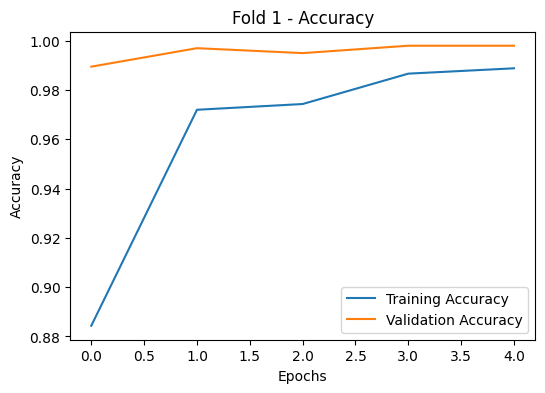

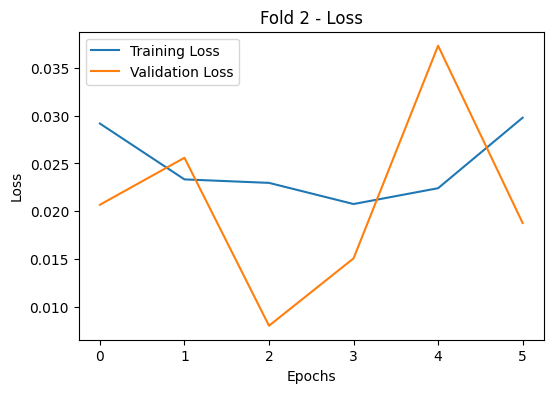

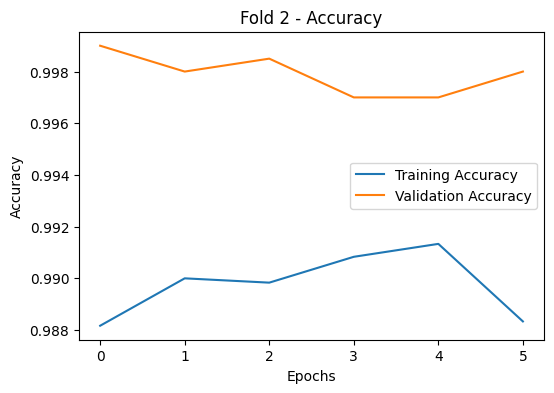

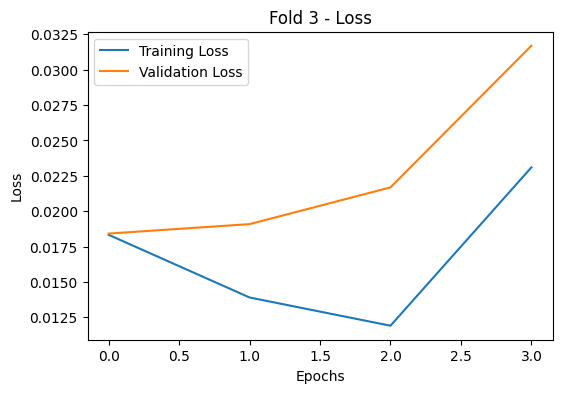

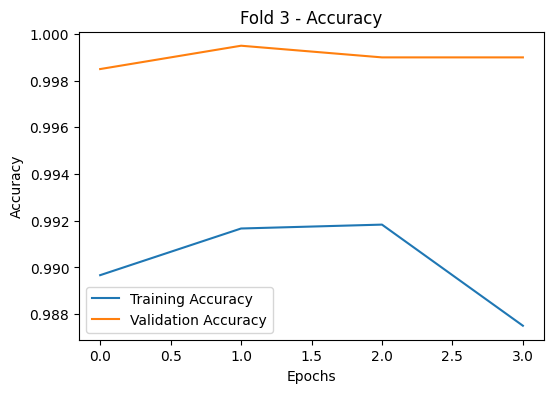

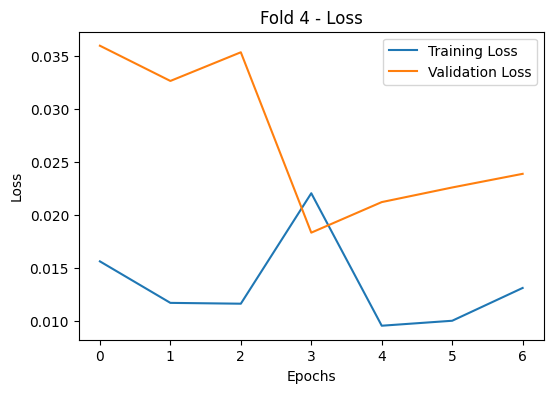

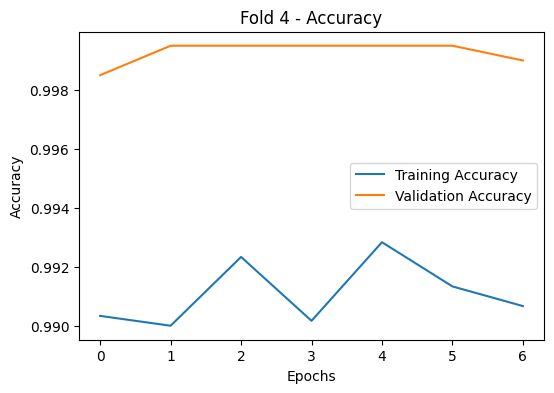

In [10]:
# iterate over the model history for all folds
for i, history in enumerate(model_history):
    # extract the loss and accuracy values for training and validation data
    fold_train_loss = history.history['loss']
    fold_val_loss = history.history['val_loss']
    fold_train_acc = history.history['accuracy']
    fold_val_acc = history.history['val_accuracy']
    
    # create a line plot for the loss values of the current fold
    plt.figure(figsize=(6, 4))
    plt.plot(fold_train_loss, label='Training Loss')
    plt.plot(fold_val_loss, label='Validation Loss')
    plt.title('Fold {} - Loss'.format(i+1))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    # create a line plot for the accuracy values of the current fold
    plt.figure(figsize=(6, 4))
    plt.plot(fold_train_acc, label='Training Accuracy')
    plt.plot(fold_val_acc, label='Validation Accuracy')
    plt.title('Fold {} - Accuracy'.format(i+1))
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [11]:
out = model.evaluate(validation_generator)
print(out[1])

63/63 [==============================] - 5s 83ms/step - loss: 0.0239 - accuracy: 0.9990
0.9990000128746033


In [12]:
from sklearn.metrics import classification_report, roc_curve, auc

# Make predictions on the X_test
y_pred_prob = model.predict(validation_generator)

# Round the predicted probabilities using the optimal threshold
y_pred = np.round(y_pred_prob)

# Get the class names from the generator
class_names = list(validation_generator.class_indices.keys())

# Generate classification report
print(classification_report(validation_generator.classes,y_pred, target_names=class_names))

63/63 [==============================] - 6s 91ms/step
              precision    recall  f1-score   support

        Fake       0.51      0.51      0.51      1000
        Real       0.51      0.51      0.51      1000

    accuracy                           0.51      2000
   macro avg       0.51      0.51      0.51      2000
weighted avg       0.51      0.51      0.51      2000



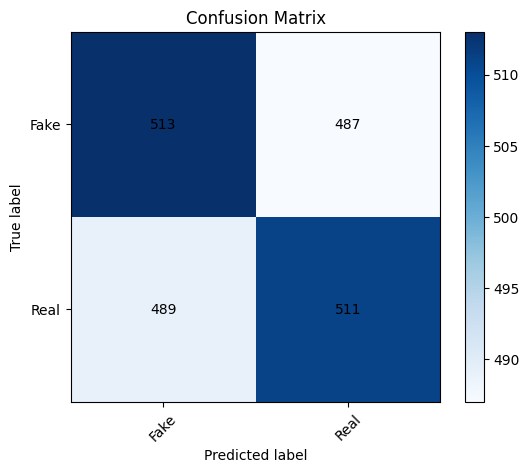

In [13]:
# plot confusion matrix
confusion_mtx = confusion_matrix(validation_generator.classes,y_pred)
plt.imshow(confusion_mtx, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
for i in range(confusion_mtx.shape[0]):
    for j in range(confusion_mtx.shape[1]):
        plt.text(j, i, str(confusion_mtx[i, j]), horizontalalignment='center', verticalalignment='center')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

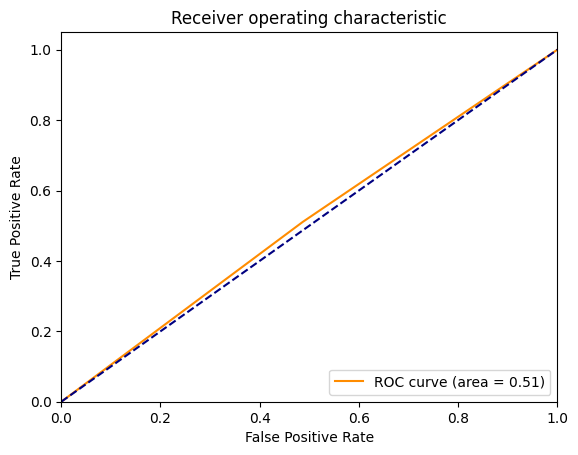

In [14]:
fpr, tpr, thresholds = roc_curve(validation_generator.classes,y_pred)
roc_auc = auc(fpr, tpr)

# plot ROC curve
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [15]:
# Make predictions on the X_test
y_pred_prob = model.predict(X_test)

# Round the predicted probabilities using the optimal threshold
y_pred = np.round(y_pred_prob)

# Get the class names from the generator
class_names = list(validation_generator.class_indices.keys())

# Generate classification report
print(classification_report(Y_test,y_pred, target_names=class_names))

63/63 [==============================] - 3s 44ms/step
              precision    recall  f1-score   support

        Fake       1.00      0.92      0.96      1000
        Real       0.93      1.00      0.96      1000

    accuracy                           0.96      2000
   macro avg       0.96      0.96      0.96      2000
weighted avg       0.96      0.96      0.96      2000

